In [29]:
!pip install -r requirements.txt

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report
test = pd.read_csv("./test.csv")
train = pd.read_csv("./train.csv")

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          137 non-null    object 
 1   ssc_p           137 non-null    float64
 2   ssc_b           137 non-null    object 
 3   hsc_p           137 non-null    float64
 4   hsc_b           137 non-null    object 
 5   hsc_s           137 non-null    object 
 6   degree_p        137 non-null    float64
 7   degree_t        137 non-null    object 
 8   workex          137 non-null    object 
 9   etest_p         137 non-null    float64
 10  specialisation  137 non-null    object 
 11  mba_p           137 non-null    float64
 12  salary          95 non-null     float64
 13  status          137 non-null    object 
dtypes: float64(6), object(8)
memory usage: 15.1+ KB


### Decido di droppare subito la colonna 'salary' per i troppi valori nulli

In [32]:
train = train.drop("salary", axis=1)
test = test.drop("salary", axis=1)

In [33]:
train.head()   

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,M,77.67,Others,64.89,Others,Commerce,70.67,Comm&Mgmt,No,89.0,Mkt&Fin,60.39,Placed
1,M,84.20,Central,69.40,Central,Science,65.00,Sci&Tech,Yes,80.0,Mkt&HR,52.72,Placed
2,M,52.00,Others,55.00,Others,Commerce,56.30,Comm&Mgmt,No,59.0,Mkt&Fin,64.74,Not Placed
3,M,63.00,Central,60.00,Central,Commerce,57.00,Comm&Mgmt,Yes,78.0,Mkt&Fin,54.55,Placed
4,F,60.23,Central,69.00,Central,Science,66.00,Comm&Mgmt,No,72.0,Mkt&Fin,59.47,Placed


# Funzioni:

In [34]:
def bar_chart(feature):
    gx = sns.countplot(x=feature, hue="status", data=train, palette="Paired_r")
    for rect in gx.patches:
        gx.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
    plt.show()

In [35]:
def kdeplot(feature):
    sns.kdeplot(feature[train.status=="Placed"], color='r')
    sns.kdeplot(feature[train.status=="Not Placed"], color='g')
    plt.legend(["Placed", "Not Placed"])
    plt.xlabel(feature.name)
    plt.show()

In [36]:
def encoding(dataframe):
    dataframe = dataframe.applymap(lambda x: 1 if x == 'M' else x)
    dataframe = dataframe.applymap(lambda x: 0 if x == 'F' else x)
    dataframe = dataframe.applymap(lambda x: 1 if x == 'Yes' else x)
    dataframe = dataframe.applymap(lambda x: 0 if x == 'No' else x)
    dataframe = dataframe.applymap(lambda x: 1 if x == 'Placed' else x)
    dataframe = dataframe.applymap(lambda x: 0 if x == 'Not Placed' else x)

    labelEncoder = LabelEncoder()
    dataframe['hsc_s'] = labelEncoder.fit_transform(dataframe['hsc_s'])
    dataframe['degree_t'] = labelEncoder.fit_transform(dataframe['degree_t'])
    dataframe['specialisation'] = labelEncoder.fit_transform(dataframe['specialisation'])
    return dataframe

In [37]:
def drop_columns(dataframe):
    columns_to_drop = ['ssc_b','hsc_b','etest_p','mba_p']
    dataframe = dataframe.drop(columns=columns_to_drop)
    return dataframe

# Analisi features:

Dal grafico si nota che i Maschi hanno una leggera possibilità in più di piazzamento.

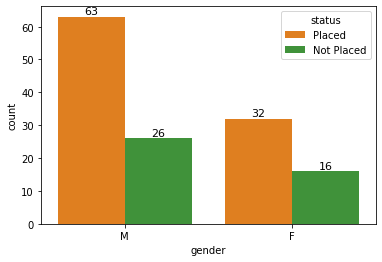

In [38]:
bar_chart("gender")

Con il seguente grafico vediamo che con un più alto punteggio di scuola media si ha più probabilità di piazzamento.

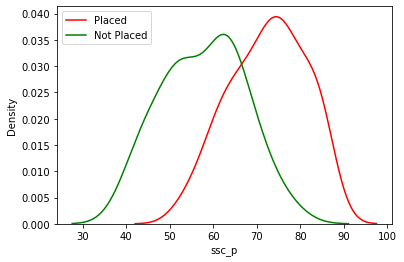

In [39]:
kdeplot(train.ssc_p)

In questo grafico vediamo che le proporzioni di piazzamento in base alla commissione sono all'incirca le stesse, non influisce quindi sul piazzamento e sarà quindi una colonna da droppare.

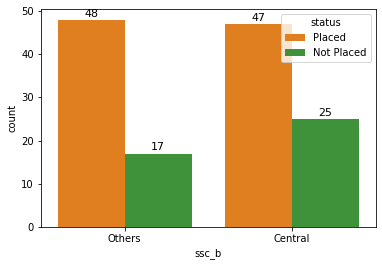

In [40]:
bar_chart("ssc_b")

Per il punteggio di diploma il discorso è analogo: più piazzamenti per punteggi superiore a ~65.

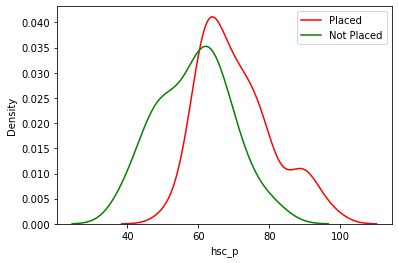

In [41]:
kdeplot(train.hsc_p)

Anche qui la commissione non influisce sul piazzamento.

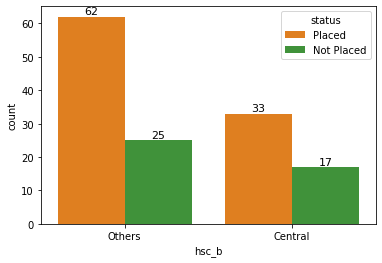

In [42]:
bar_chart("hsc_b")

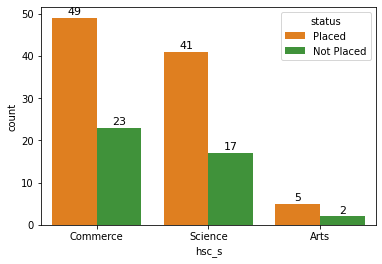

In [43]:
bar_chart("hsc_s")

Da questo grafico si nota che c'è più possibilità di piazzamento con un punteggio di laurea superiore a ~65.

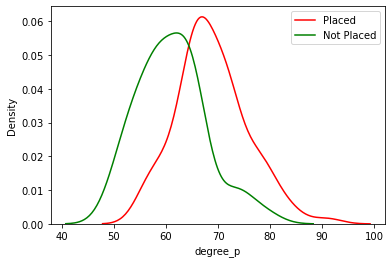

In [44]:
kdeplot(train.degree_p)

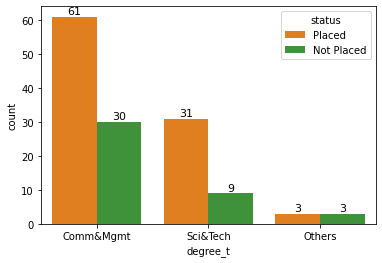

In [45]:
bar_chart("degree_t")

Questa è una feature molto importante perchè è evidente che sono pochi gli studenti con esperienza lavorativa che non vengono collocati.

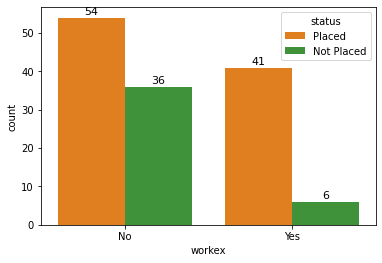

In [46]:
bar_chart("workex")

Essendoci nel grafico una certa sovrapposizione tra le due curve vuol dire che non c'è molta influenza sul piazzamento e sarà quindi una colonna da droppare.

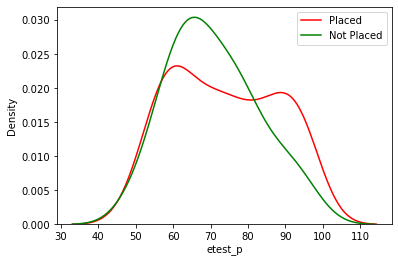

In [47]:
kdeplot(train.etest_p)

Anche questa sarà una feature importante perchè con una certa specializzazione si hanno molte più probabilità di piazzamento.

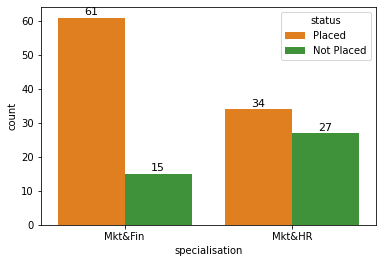

In [48]:
bar_chart("specialisation")

Data la sovrapposizione delle curve anche questa colonna verrà droppata.

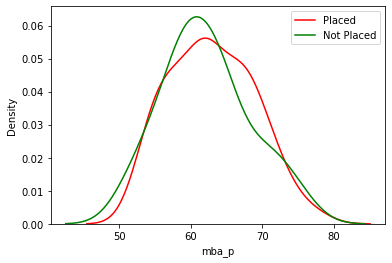

In [49]:
kdeplot(train.mba_p)

## Encoding

In [50]:
train = encoding(train)

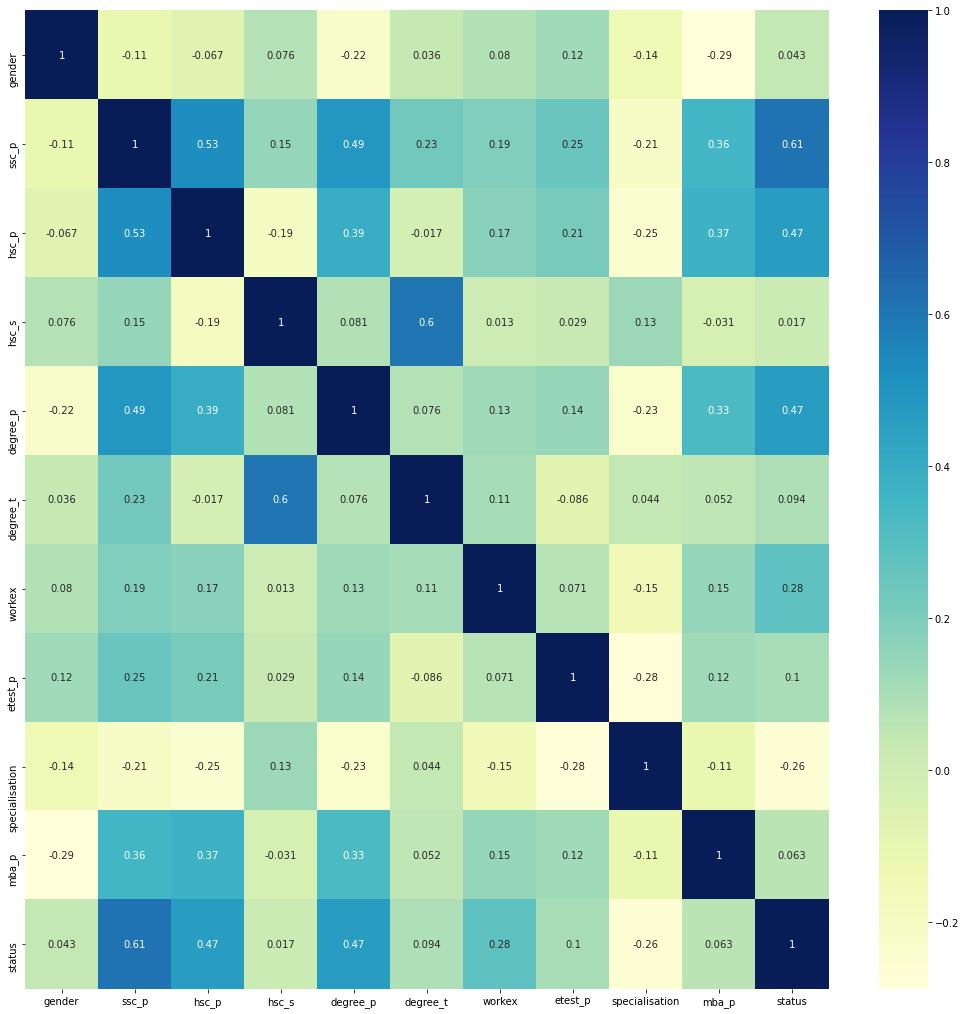

In [51]:
plt.figure(figsize=(18,18))
sns.heatmap(train.corr(),annot=True,cmap='YlGnBu')

plt.show()

## Drop colonne
Drop delle colonne in base ai precedenti grafici

In [52]:
train = drop_columns(train)

## Preparazione insieme di test

In [53]:
test = encoding(test)
test = drop_columns(test)

# Training
Uso del RandomForest perchè più efficace del DecisionTree, in quanto usa più alberi di decisione con una conseguente votazione sulla predizione.

In [54]:
y_train = train["status"].copy()
X_train = train.drop("status",axis=1).copy()

y_test = test["status"].copy()
X_test = test.drop("status",axis=1).copy()

In [62]:
model = RandomForestClassifier()
model = model.fit(X_train, y_train)
    
pred = model.predict(X_test)
print("Accuracy:", accuracy_score(pred, y_test) * 100)

plt.show()

Accuracy: 94.28571428571428
